In [19]:
import dlib
# Keras imports : model, layers, optimizers
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras.initializers import HeNormal
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder

In [20]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [21]:
def load_data(dataset_path):
    """
    Loads video frames from a dataset directory and prepares them for prediction of directory name.

    Args:
        dataset_path (str): Path to the dataset directory containing labeled dictionaries.
        img_height (int, optional): Target image height for resizing (if desired). Defaults to None.
        img_width (int, optional): Target image width for resizing (if desired). Defaults to None.

    Returns:
        tuple: A tuple containing the following elements:
            - X (list): List of NumPy arrays representing video frames for prediction.
            - Y (list): List of true directory names (labels) corresponding to the frames in X.
    """

    Xtrain , Y_train , Xvalid,Y_valid, Xtest, Y_test = [], [], [], [], [], []

    for label_dir in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_dir)
        if not os.path.isdir(label_path):
            continue
        for data_type in ['train', 'val', 'test']:  # Assuming all data in one directory
            data_type_path = os.path.join(label_path, data_type)

            for filename in os.listdir(data_type_path):
                if filename.endswith('.mp4'):
                    video_path = os.path.join(data_type_path, filename)

                    # Use opencv to read video frames efficiently
                    cap = cv2.VideoCapture(video_path)
                    frames = []
                    while True:
                        ret, frame = cap.read()
                        if not ret:
                            break
                        frames.append(frame)
                    cap.release()
                    if data_type == 'train':
                        Xtrain.append(np.array(frames))
                        Y_train.append(label_dir)
                    elif data_type == 'val':
                        Xvalid.append(np.array(frames))
                        Y_valid.append(label_dir)
                    elif data_type == 'test':
                        Xtest.append(np.array(frames))
                        Y_test.append(label_dir)

    onehot_encoder = OneHotEncoder()
    
    Y_train_reshaped = np.array(Y_train).reshape(-1, 1)
    Y_valid_reshaped = np.array(Y_valid).reshape(-1, 1)
    Y_test_reshaped = np.array(Y_test).reshape(-1, 1)

    Y_train_onehot = onehot_encoder.fit_transform(Y_train_reshaped)
    Y_valid_onehot = onehot_encoder.fit_transform(Y_valid_reshaped)
    Y_test_onehot = onehot_encoder.fit_transform(Y_test_reshaped)

    # Convert one-hot encoded arrays to dense arrays
    Y_train = Y_train_onehot.toarray()
    Y_valid = Y_valid_onehot.toarray()
    Y_test = Y_test_onehot.toarray()


    return Xtrain , Y_train , Xvalid,Y_valid, Xtest, Y_test

In [ ]:
data_src = "C:/Users/marko/Documents/Bsc_4_felev/ait/projekt/lipread"

#write a code that loads data just the first directory from the path
Xtrain , Y_train , Xvalid,Y_valid, Xtest, Y_test = load_data(data_src)

In [ ]:
def to_gray(images):
    newImages=[]
    gray_frames = []
    for i in range(len(images)):
        for j in range(len(images[i])):
            gray_img = cv2.cvtColor(images[i][j], cv2.COLOR_BGR2GRAY)
            gray_img = cv2.resize(gray_img, (256, 256))
            gray_frames.append(gray_img)
        newImages.append(np.array(gray_frames))
        gray_frames.clear()
    return newImages

In [ ]:
#convert every frame in the X_train, X_valid and X_test to grayscale
X_train = to_gray(Xtrain)
X_valid = to_gray(Xvalid)
X_test = to_gray(Xtest)

In [6]:
print(len(X_train))
print(X_train[0].shape)
print(X_train[0][0].shape) 

2000
(29, 256, 256, 1)
(256, 256, 1)


In [7]:
print(len(X_valid))
print(X_valid[0].shape)
print(X_valid[0][0].shape)

100
(29, 256, 256, 1)
(256, 256, 1)


In [8]:
print(len(X_test))
print(X_test[0].shape)
print(X_test[0][0].shape)

100
(29, 256, 256, 1)
(256, 256, 1)


In [9]:
print(len(Y_train))
print(len(Y_valid))
print(len(Y_test))

2000
100
100


In [10]:
print(Y_train[0])
print(Y_train[504])
print(len(np.unique(Y_train)))

print(Y_valid[0])
print(Y_valid[54])
print(len(np.unique(Y_valid)))

print(Y_test[0])
print(Y_test[54])
print(len(np.unique(Y_test)))

[0. 1.]
[0. 1.]
2
[0. 1.]
[1. 0.]
2
[0. 1.]
[1. 0.]
2


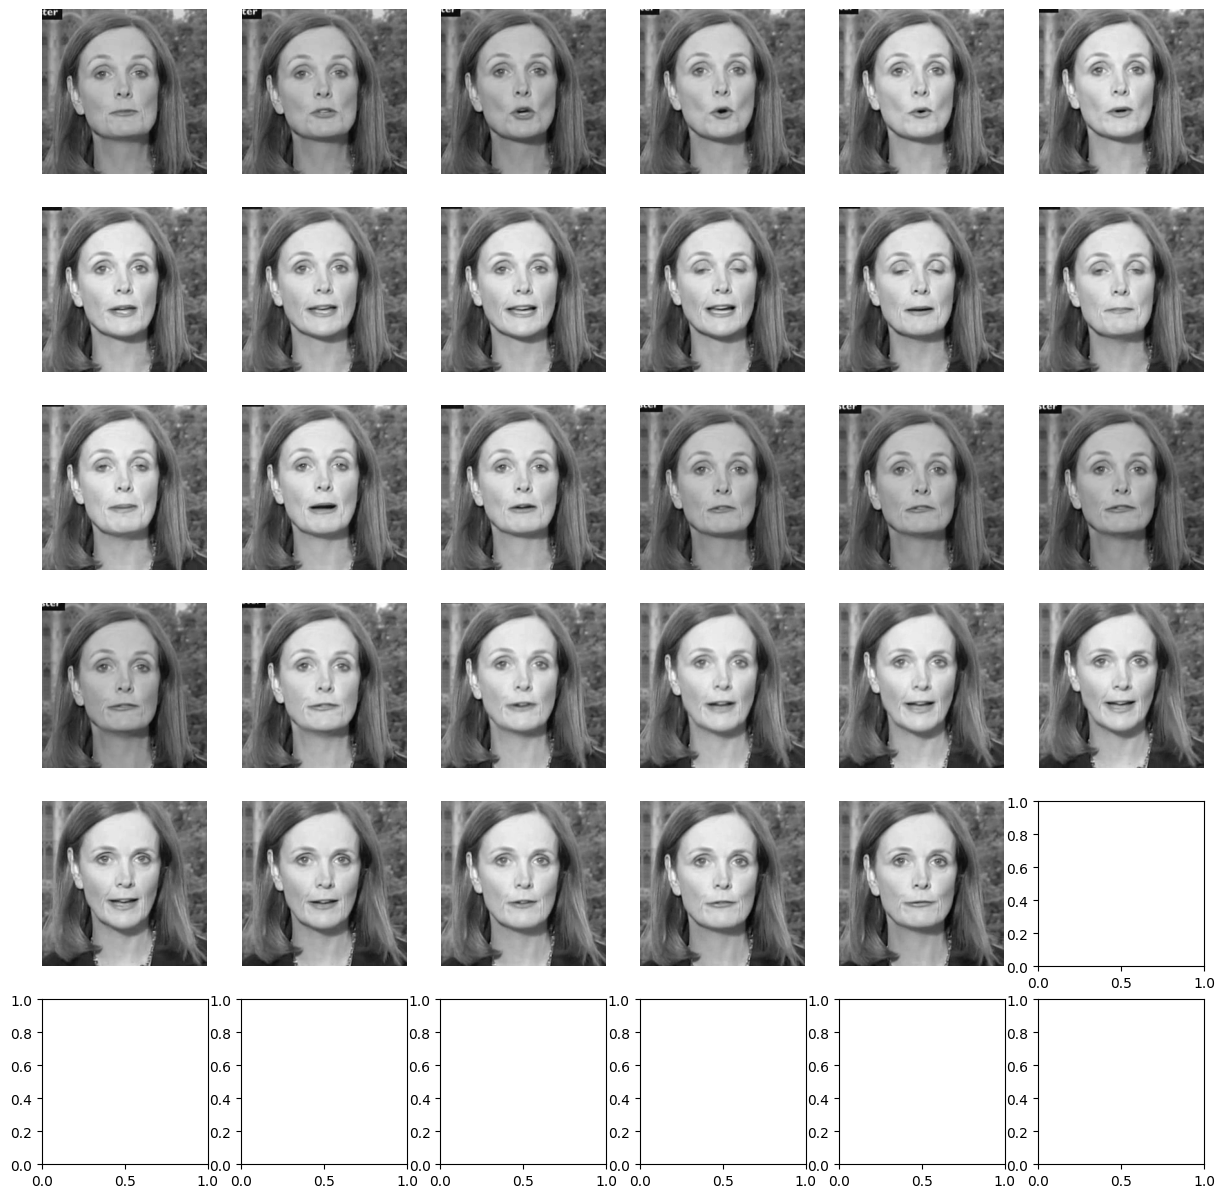

In [11]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for i in range(29):
    row = i // 6
    col = i % 6
    ax[row, col].imshow(X_train[0][i], cmap='gray')
    ax[row, col].axis('off')
plt.show()

Face detecting

In [12]:
def face_detect(face_classifier, images, labels):
    detected_faces_list = []
    to_be_removed_indices = []
    for i in range(len(images)):
        detected_faces = []
        for j in range(len(images[i])):
            face = face_classifier.detectMultiScale(
                images[i][j], scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
            )
            if len(face) == 1:
                for (x, y, w, h) in face:
                    cv2.rectangle(images[i][j], (x, y), (x + w, y + h), (0, 255, 0), 4)
                    detected_faces.append((x, y, w, h))
        if len(detected_faces) == 29:
            detected_faces_list.append(detected_faces)
        else:
            to_be_removed_indices.append(i)
    # Remove images and labels based on indices
    detected_images = [images[i] for i in range(len(images)) if i not in to_be_removed_indices]
    detected_labels = [labels[i] for i in range(len(labels)) if i not in to_be_removed_indices]
    
    return detected_faces_list, detected_images, detected_labels

In [14]:
#loading the Haar Cascade classifier for face detection
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
detected_faces_train, X_train_new, Y_train_new = face_detect(face_classifier, X_train, Y_train)
detected_faces_valid, X_valid_new, Y_valid_new = face_detect(face_classifier, X_valid, Y_valid)
detected_faces_test, X_test_new, Y_test_new = face_detect(face_classifier, X_test, Y_test)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1389: error: (-215:Assertion failed) scaleFactor > 1 && _image.depth() == CV_8U in function 'cv::CascadeClassifierImpl::detectMultiScale'


In [ ]:
print(len(detected_faces_valid))
print(len(detected_faces_valid[0]))
print(len(X_valid_new))

In [ ]:
print(len(detected_faces_train))
print(len(detected_faces_train[0]))
print(len(X_train_new))

In [ ]:
print(len(detected_faces_test))
print(len(detected_faces_test[0]))
print(len(X_test_new))

In [ ]:
print(len(Y_train_new))
print(len(Y_valid_new))
print(len(Y_test_new))

In [ ]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for i in range(29):
    row = i // 6
    col = i % 6
    ax[row, col].imshow(X_train_new[0][i], cmap='gray')
    ax[row, col].axis('off')
plt.show()

Facial landmark detecting

In [ ]:
def lip_detect(images, og_images):
    lips_return_list = []
    for i in range(len(images)):
        lips_list = []
        for j in range(len(images[i])):
            frame = og_images[i][j]
            x, y, w, h = images[i][j] 
            face_box = dlib.rectangle(left=x, top=y, right=x + w, bottom=y + h)
            shape = predictor(frame, face_box) 
            shape = face_utils.shape_to_np(shape)
        
            (x, y, w, h) = cv2.boundingRect(np.array([shape[48:68]]))
            margin = 10
            lips = frame[y-margin:y+h+margin, x-margin:x+w+margin]
            lips = cv2.resize(lips,(100,60))
            lips_list.append(lips)
        lips_return_list.append(lips_list)
    return lips_return_list

In [ ]:
from imutils import face_utils
import dlib

predictor_path = r'C:/Users/marko/Documents/Bsc_4_felev/ait/projekt/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(predictor_path)
lips_train_list = lip_detect(detected_faces_train, X_train_new)
lips_valid_list = lip_detect(detected_faces_valid, X_valid_new)
lips_test_list = lip_detect(detected_faces_test, X_test_new)
lips_train = np.array(lips_train_list)
lips_valid = np.array(lips_valid_list)
lips_test = np.array(lips_test_list)

In [ ]:
print(lips_train_array.shape)
print(lips_valid_array.shape)
print(lips_test_array.shape)
print(Y_train.shape)
print(Y_valid.shape)
print(Y_test.shape)

In [ ]:
print(len(lips_train))
print(len(lips_train[0]))
print(len(lips_valid))
print(len(lips_valid[0]))
print(len(lips_test))
print(len(lips_test[0]))

In [ ]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for i in range(29):
    row = i // 6
    col = i % 6
    ax[row, col].imshow(lips_train[0][i], cmap='gray')
    ax[row, col].axis('off')
plt.show()

Calculating average word duration for help with the training (determining how many frames to include for training)

In [ ]:
def mean_duration(dataset_path):
    duration = []
    videos = 0
    for label_dir in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label_dir)
        if not os.path.isdir(label_path):
            continue
        for data_type in ['train', 'val', 'test']:  # Assuming all data in one directory
            data_type_path = os.path.join(label_path, data_type)

            for filename in os.listdir(data_type_path):
                if filename.endswith('.txt'):
                    text_path = os.path.join(data_type_path, filename)
                    videos = videos + 1
                    data = []
                    with open(text_path, 'rt') as file:
                        for line in file:
                            data.append(line)
                        
                        time = float(data[-1].split()[1])
                        duration.append(time)
    return np.mean(duration), videos

In [ ]:
import math

data_source ="C:/Users/marko/Documents/Bsc_4_felev/ait/projekt/lipreadmp4/lipreadmp4"
# one video in the dataset is 1.16 seconds long (29 frames)
video_dur = 1.16
mean_dur, nr = mean_duration(data_source)

# calculating the number of frames to include in the training
# actual frames that correspond to the word being spoken
frame_num = math.ceil(mean_dur * 29 / video_dur)

In [ ]:
print(mean_dur)
print(nr)
print(frame_num)

In [ ]:
# chosing the middle frames from the 29 frames in every video
def get_middle_frames(lips, frame_num):
    separator = (29 - frame_num) // 2
    middle_frames = lips[separator:separator + frame_num]
    return middle_frames

In [ ]:
for i in range(len(lips_train)):
    lips_train[i] = get_middle_frames(lips_train[i], frame_num)
for i in range(len(lips_valid)):
    lips_valid[i] = get_middle_frames(lips_valid[i], frame_num)
for i in range(len(lips_test)):
    lips_test[i] = get_middle_frames(lips_test[i], frame_num)

In [ ]:
print(len(lips_train))
print(len(lips_train[0]))
print(len(lips_valid))
print(len(lips_valid[0]))
print(len(lips_test))
print(len(lips_test[0]))

In [ ]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for i in range(len(lips_train[0])):
    row = i // 6
    col = i % 6
    ax[row, col].imshow(lips_train[0][i], cmap='gray')
    ax[row, col].axis('off')
plt.show()

Spatiotemporal front-end

In [ ]:
3D conv + 2D resnet??? i dont know how it works, really xddd

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, ReLU, GlobalAveragePooling3D, add
from keras.models import Model

output_shape = 2
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer = 'he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)
b0_out =  MaxPooling3D(pool_size=(2, 2, 2))(b0_bn_1)

'''block_1'''
b1_cnv2d_1 = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same',
                        use_bias=False, name='b1_cnv2d_1', kernel_initializer=HeNormal())(b0_out)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv2d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv2d_2 = Conv2D(filters=32, kernel_size=(1, 1), strides=(2, 2), padding='same',
                    use_bias=False, name='b1_cnv2d_2', kernel_initializer=HeNormal())(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv2d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14


'''block 2'''
b2_cnv2d_1 = Conv2D(filters=32, kernel_size=(1, 1), strides=(1, 1), padding='same',
                    use_bias=False, name='b2_cnv2d_1', kernel_initializer=HeNormal())(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv2d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv2d_2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                    use_bias=False, name='b2_cnv2d_2', kernel_initializer=HeNormal())(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv2d_2)
b2_out = BatchNormalization(name='b2_bn_2')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv2d_1 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same',
                    use_bias=False, name='b3_cnv2d_1', kernel_initializer=HeNormal())(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv2d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv2d_2 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                    use_bias=False, name='b3_cnv2d_2', kernel_initializer=HeNormal())(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv2d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3


'''block 4'''
b4_avg_p = GlobalAveragePooling3D()(b3_out)
output = Dense(output_shape, name='model_output', activation='softmax',
                       kernel_initializer='he_uniform')(b4_avg_p)

model = Model(input, output)

In [ ]:
model.summary()

i changed the conv2d layers in the previous model to conv3d, somehow the summary is the same
3d resnet?

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, ReLU, GlobalAveragePooling3D, add
from keras.models import Model

output_shape = 2
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer = 'he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)
b0_out =  MaxPooling3D(pool_size=(2, 2, 2))(b0_bn_1)

'''block_1'''
b1_cnv3d_1 = Conv3D(filters=16, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                        use_bias=False, name='b1_cnv3d_1', kernel_initializer=HeNormal())(b0_out)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv3d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv3d_2 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b1_cnv3d_2', kernel_initializer=HeNormal())(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv3d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14


'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer=HeNormal())(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer=HeNormal())(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_bn_2')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer=HeNormal())(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer=HeNormal())(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3


'''block 4'''
b4_avg_p = GlobalAveragePooling3D()(b3_out)
output = Dense(output_shape, name='model_output', activation='softmax',
                       kernel_initializer='he_uniform')(b4_avg_p)

model = Model(input, output)

In [ ]:
model.summary()

In [ ]:
print(model.output_shape)

In [ ]:
es = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)

In [ ]:
# loss function and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training
network_history = model.fit(lips_train_array, Y_train, batch_size=16, epochs=30, verbose=1, validation_data=(lips_valid_array, Y_valid), callbacks=[es])

In [ ]:
probas = model.predict(lips_test_array)
preds  = np.argmax(probas,axis=1)
Y_test_dense = np.argmax(Y_test, axis=1) # get the original dense labels of the test data

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(Y_test_dense, preds)
precision = precision_score(Y_test_dense, preds, average='macro')
recall = recall_score(Y_test_dense, preds, average='macro')
f1 = f1_score(Y_test_dense, preds, average='macro')

In [ ]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)